In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler

SEED = 12345
import random, numpy as np
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. EDA

In [3]:
def load_and_explore_data(file_path):

    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    print(f"Date range: {df['From Date'].min()} to {df['From Date'].max()}")

    df['From Date'] = pd.to_datetime(df['From Date'])
    df['To Date'] = pd.to_datetime(df['To Date'])

    print("\nDataset Info:")
    print(df.info())

    print("\nMissing Values:")
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing_counts, 'Missing Percentage': missing_percentage}).sort_values('Missing Percentage', ascending=False)
    print(missing_df[missing_df['Missing Count'] > 0])

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 1. Histogram
    axes[0].hist(df['AT (degree C)'].dropna(), bins=50, alpha=0.7, color='skyblue')
    axes[0].set_title('Distribution of Air Temperature (AT)')
    axes[0].set_xlabel('Temperature (C)')
    axes[0].set_ylabel('Frequency')

    # 2. Time Series
    df_sample = df.iloc[::100]
    axes[1].plot(df_sample['From Date'], df_sample['AT (degree C)'], alpha=0.7)
    axes[1].set_title('Air Temperature Over Time')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Temperature (C)')
    axes[1].tick_params(axis='x', rotation=45)

    # 3. Hourly Pattern
    df['hour'] = df['From Date'].dt.hour
    hourly_temp = df.groupby('hour')['AT (degree C)'].mean()
    axes[2].plot(hourly_temp.index, hourly_temp.values, marker='o')
    axes[2].set_title('Average Temperature by Hour of Day')
    axes[2].set_xlabel('Hour')
    axes[2].set_ylabel('Average Temperature (C)')

    # 4. STL
    from statsmodels.tsa.seasonal import STL
    ts = df.set_index('From Date')['AT (degree C)'].asfreq('h')
    ts = ts.interpolate(method='linear')
    stl = STL(ts, period=24)
    res = stl.fit()
    res.plot()
    plt.suptitle('STL Decomposition of Air Temperature', fontsize=14)

    plt.tight_layout()
    plt.show()

    return df

Dataset shape: (48802, 25)
Date range: 2017-09-05 14:00:00 to 2023-03-31 23:00:00

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48802 entries, 0 to 48801
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   From Date            48802 non-null  datetime64[ns]
 1   To Date              48802 non-null  datetime64[ns]
 2   PM2.5 (ug/m3)        46344 non-null  float64       
 3   PM10 (ug/m3)         46917 non-null  float64       
 4   NO (ug/m3)           47244 non-null  float64       
 5   NO2 (ug/m3)          47224 non-null  float64       
 6   NOx (ppb)            46628 non-null  float64       
 7   NH3 (ug/m3)          47140 non-null  float64       
 8   SO2 (ug/m3)          46649 non-null  float64       
 9   CO (mg/m3)           46387 non-null  float64       
 10  Ozone (ug/m3)        47156 non-null  float64       
 11  Benzene (ug/m3)      46914 non-null  float64    

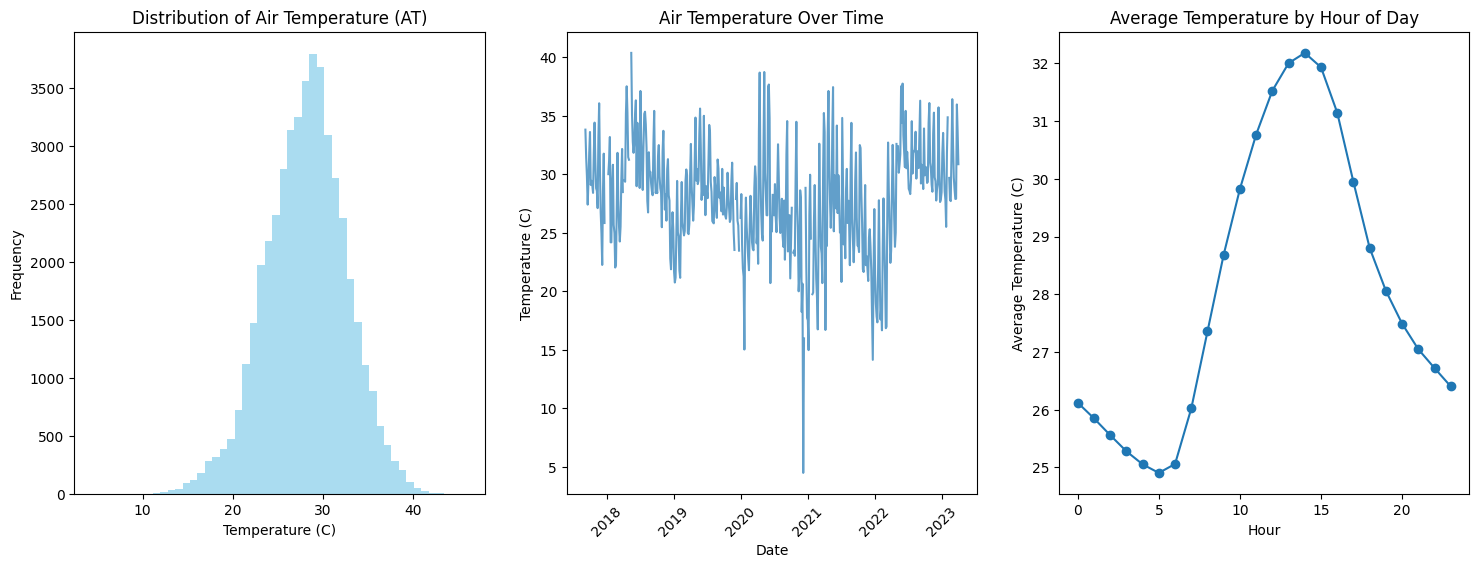

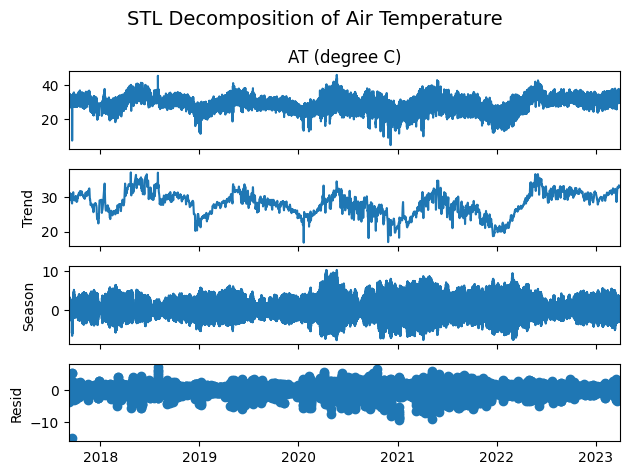

In [4]:
df = load_and_explore_data('AP004.csv')

dari EDA tersebut, bisa disimpulkan bahwa semua kolom memiliki missing values

1. Histogram dari suhu udara (AT) menunjukkan ada di rata rata 28-32 celcius. Tidak terlalu Skewed
2. Suhu udara over time itu merupakan plot time series yang diambil tiap 100 baris (pake slicing syntax)
3. Rata Rata suhu per jam, untuk melihat suhu itu peak dan low nya di jam ke berapa?
4. STL decomposition. AT Degree C, bisa dilihat fluktuatif. Dari plot trend, terlihat ada penurunan suhu setiap diakhir dan awal tahun, mulai meningkat di pertengahan, namun di tahun 2023, suhu tidak menurun seperti di tahun sebelumnya. Seasonal di STL menunjukan pola yang rata, hal ini berarti pola harian sangant konsisten dan dominan dari data yang dihitung bertahun-tahun. Residual di angka 0 menunjukkan keberhasilan karena model dekomposisi STL berhasil menangkap sebagian besar pola di dalam data. Rumusnya residual = Data - (trend + seasonal), yang berarti semakin trend dan seasonal sudah diamati dengan baik, maka residual akan ada di sekitar 0.

In [5]:
df.describe()

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3),hour
count,46344.000000,46917.000000,47244.000000,47224.000000,46628.000000,47140.000000,46649.000000,46387.000000,47156.000000,46914.000000,...,47364.000000,47375.000000,47373.000000,47146.000000,47373.000000,47176.000000,47286.000000,47510.000000,47075.000000,48802.000000
mean,34.821967,71.598595,2.509505,15.284711,10.025558,13.382927,8.498869,0.693976,40.931671,0.570979,...,69.547402,2.758707,184.428806,193.844929,752.029991,0.006144,28.083312,0.037863,0.733060,11.501434
std,30.785200,48.312579,5.058787,10.415231,7.179902,7.847778,6.086666,0.437964,32.651348,0.800774,...,14.900450,1.441744,65.375666,191.882654,5.047151,0.092525,4.458718,0.444720,1.302384,6.922395
min,0.250000,0.250000,0.030000,0.100000,0.000000,0.100000,0.100000,0.000000,0.200000,0.000000,...,15.000000,0.200000,45.330000,0.000000,736.500000,-0.280000,4.500000,0.000000,0.000000,0.000000
25%,12.000000,34.500000,1.450000,8.450000,6.000000,8.200000,4.920000,0.430000,14.730000,0.100000,...,59.250000,1.620000,123.750000,3.500000,748.000000,-0.020000,25.170000,0.000000,0.100000,6.000000
50%,25.000000,59.750000,1.900000,12.800000,8.470000,11.900000,7.250000,0.630000,33.230000,0.350000,...,72.750000,2.550000,187.750000,111.750000,752.500000,0.000000,28.270000,0.000000,0.330000,12.000000
75%,51.250000,100.500000,2.600000,19.300000,12.150000,17.000000,10.370000,0.880000,59.680000,0.830000,...,81.250000,3.670000,240.500000,402.250000,756.000000,0.040000,31.050000,0.000000,0.800000,18.000000
max,723.000000,835.500000,216.170000,166.250000,166.000000,118.250000,183.300000,18.690000,198.400000,50.900000,...,100.000000,45.900000,326.000000,455.750000,808.250000,15.000000,45.850000,42.200000,64.020000,23.000000


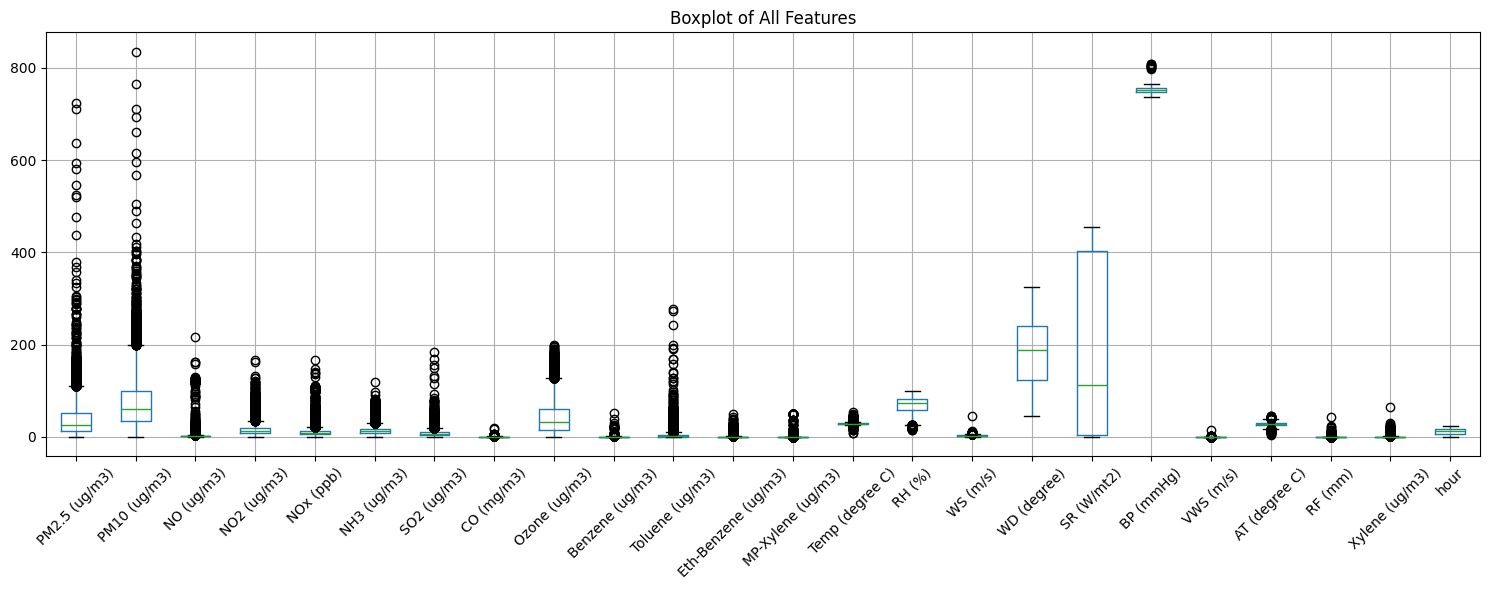

In [6]:
df.boxplot(figsize=(15, 6), rot=45)
plt.title('Boxplot of All Features')
plt.grid(True)

plt.tight_layout()
plt.show()

# 2. Pre Processing

jadikan kolom from date jadi index

In [7]:
df['From Date'] = pd.to_datetime(df['From Date'])
df = df.set_index('From Date')

karena target missing, harus lakuin interpolasi untuk impute mmissing value.
Tidak boleh drop karena akan membuat data separated

In [8]:
df['AT (degree C)'] = df['AT (degree C)'].interpolate(method="time")
df = df.reset_index()

In [9]:
df["AT (degree C)"].isna().sum()

0

liat duplicate value, ada ga?

In [10]:
print("Jumlah baris duplikat:", df.duplicated().sum())

Jumlah baris duplikat: 0


Delete column yang missingnya banyak

In [11]:
df = df.drop(columns=[
    'Temp (degree C)',  # 50%
    'Eth-Benzene (ug/m3)', # 50%
    'MP-Xylene (ug/m3)', # 20%
    'To Date'
])

nambahkan kolom hour dan month ke data

In [12]:
df['hour'] = df['From Date'].dt.hour
df['month'] = df['From Date'].dt.month

Using cyclical encoding for hour and month

In [13]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df.drop(['hour', 'month'], axis=1, inplace=True)

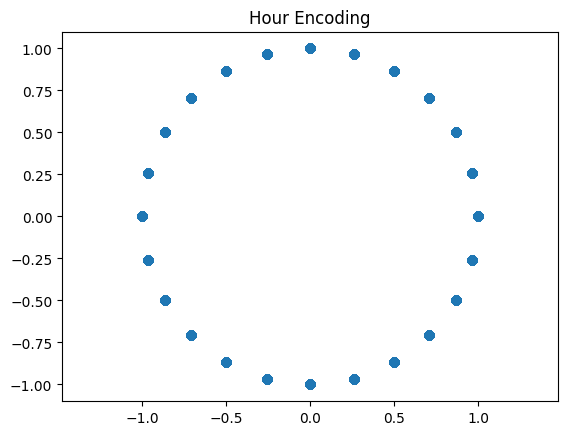

In [14]:
plt.scatter(df['hour_cos'], df['hour_sin'])
plt.title('Hour Encoding')
plt.axis('equal')
plt.show()

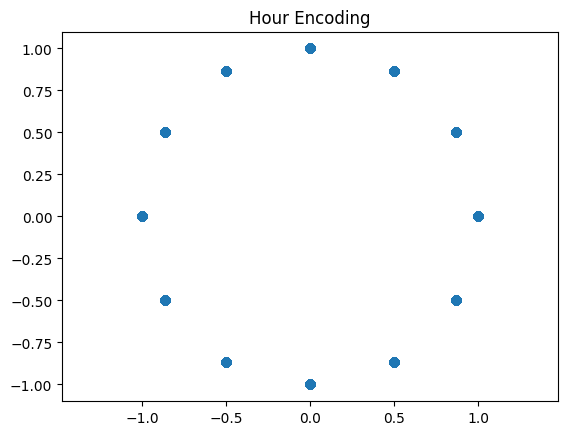

In [15]:
plt.scatter(df['month_cos'], df['month_sin'])
plt.title('Hour Encoding')
plt.axis('equal')
plt.show()

In [16]:
df

,From Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),...,SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3),hour_sin,hour_cos,month_sin,month_cos
0,2017-09-05 14:00:00,25.00,45.00,1.80,12.20,7.90,10.20,5.60,0.35,79.50,...,372.00,747.00,0.10,33.80,0.00,0.50,-0.500000,-8.660254e-01,-1.0,-1.836970e-16
1,2017-09-05 15:00:00,23.00,49.50,0.65,14.55,8.28,8.85,4.52,0.41,62.50,...,290.75,747.25,0.05,32.22,0.00,0.48,-0.707107,-7.071068e-01,-1.0,-1.836970e-16
2,2017-09-05 16:00:00,18.00,55.75,4.00,26.58,17.40,6.23,5.35,0.38,40.50,...,300.25,747.00,0.00,28.30,0.93,0.53,-0.866025,-5.000000e-01,-1.0,-1.836970e-16
3,2017-09-05 17:00:00,19.75,33.50,1.63,21.78,12.92,8.30,5.30,0.48,34.43,...,225.50,747.75,0.00,28.77,0.00,1.85,-0.965926,-2.588190e-01,-1.0,-1.836970e-16
4,2017-09-05 18:00:00,14.00,28.00,1.07,26.38,14.90,3.42,4.68,0.43,33.00,...,11.25,748.25,0.00,28.25,0.00,2.17,-1.000000,-1.836970e-16,-1.0,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48797,2023-03-31 19:00:00,10.75,29.25,2.98,8.18,6.77,6.10,8.90,0.50,7.12,...,3.00,751.75,0.06,33.58,0.00,0.53,-0.965926,2.588190e-01,1.0,6.123234e-17
48798,2023-03-31 20:00:00,9.75,28.75,3.15,9.88,7.77,6.10,10.43,0.68,7.28,...,3.00,752.00,0.07,32.52,0.00,0.50,-0.866025,5.000000e-01,1.0,6.123234e-17
48799,2023-03-31 21:00:00,16.75,33.75,2.95,14.32,10.00,7.90,12.17,0.86,7.05,...,3.00,752.50,0.07,31.20,0.00,0.75,-0.707107,7.071068e-01,1.0,6.123234e-17
48800,2023-03-31 22:00:00,12.75,34.75,1.98,13.60,8.80,10.12,18.57,0.76,7.02,...,3.50,753.00,0.06,30.85,0.00,0.70,-0.500000,8.660254e-01,1.0,6.123234e-17


# Split

In [17]:
train, val, test = np.split(df, [int(.8 * len(df)), int(.9 * len(df))])

In [18]:
print(f"Training set: {len(train)}")
print(f"Validation set: {len(val)}")
print(f"Test set: {len(test)}")

Training set: 39041
Validation set: 4880
Test set: 4881


# Impute

In [19]:
missing_counts = df.isnull().sum()
missing_counts

From Date             0
PM2.5 (ug/m3)      2458
PM10 (ug/m3)       1885
NO (ug/m3)         1558
NO2 (ug/m3)        1578
NOx (ppb)          2174
NH3 (ug/m3)        1662
SO2 (ug/m3)        2153
CO (mg/m3)         2415
Ozone (ug/m3)      1646
Benzene (ug/m3)    1888
Toluene (ug/m3)    1894
RH (%)             1438
WS (m/s)           1427
WD (degree)        1429
SR (W/mt2)         1656
BP (mmHg)          1429
VWS (m/s)          1626
AT (degree C)         0
RF (mm)            1292
Xylene (ug/m3)     1727
hour_sin              0
hour_cos              0
month_sin             0
month_cos             0
dtype: int64

In [20]:
print("Null values in train data:\n", np.isnan(train).sum())
print("Null values in val data:\n", np.isnan(val).sum())
print("Null values in test data:\n", np.isnan(test).sum())

Null values in train data:
 From Date             0
PM2.5 (ug/m3)      2041
PM10 (ug/m3)       1760
NO (ug/m3)         1443
NO2 (ug/m3)        1463
NOx (ppb)          2066
NH3 (ug/m3)        1410
SO2 (ug/m3)        1728
CO (mg/m3)         2113
Ozone (ug/m3)      1481
Benzene (ug/m3)    1762
Toluene (ug/m3)    1768
RH (%)             1328
WS (m/s)           1324
WD (degree)        1326
SR (W/mt2)         1553
BP (mmHg)          1326
VWS (m/s)          1523
AT (degree C)         0
RF (mm)            1189
Xylene (ug/m3)     1601
hour_sin              0
hour_cos              0
month_sin             0
month_cos             0
dtype: int64
Null values in val data:
 From Date            0
PM2.5 (ug/m3)      236
PM10 (ug/m3)        80
NO (ug/m3)          73
NO2 (ug/m3)         78
NOx (ppb)           72
NH3 (ug/m3)        128
SO2 (ug/m3)         99
CO (mg/m3)         194
Ozone (ug/m3)      100
Benzene (ug/m3)     86
Toluene (ug/m3)     86
RH (%)              78
WS (m/s)            71
WD (degree)

Visualisasi missing value

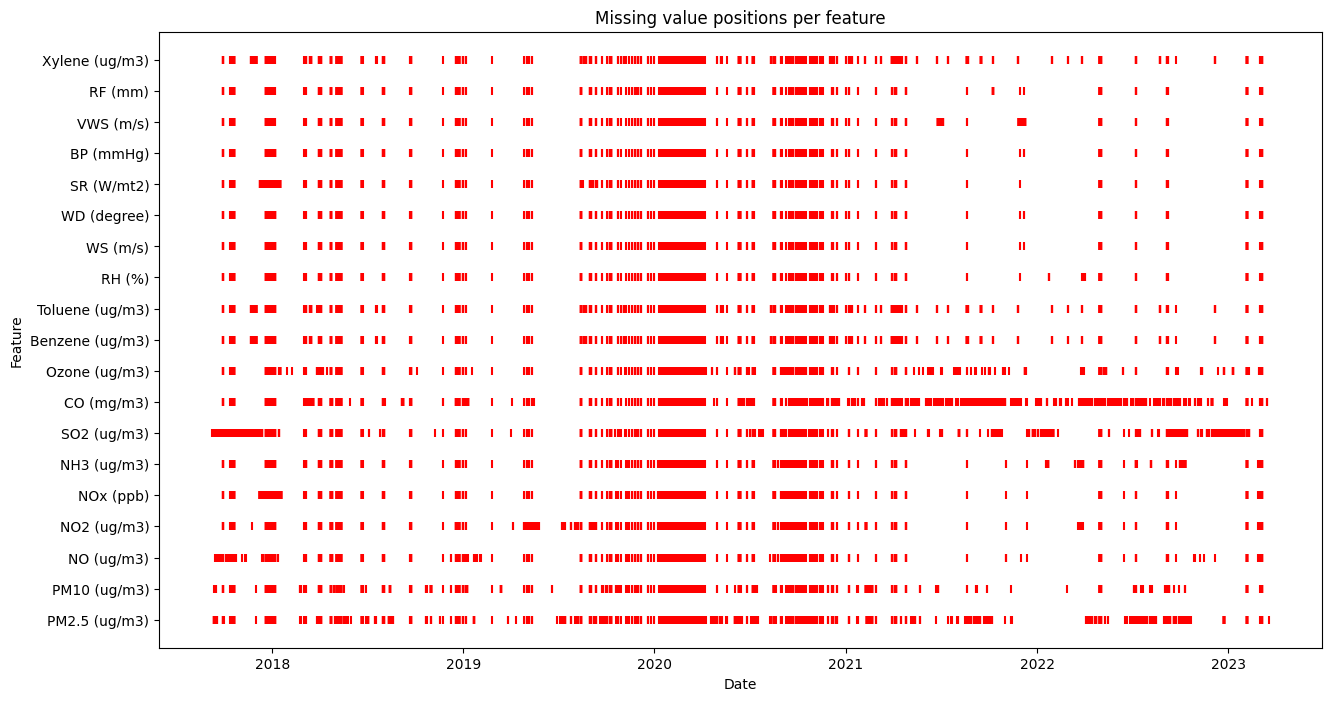

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
for i, col in enumerate(df, start=1):  
    missing_dates = df.loc[df[col].isna(), "From Date"]
    plt.scatter(missing_dates, [col]*len(missing_dates), marker="|", color="red")
plt.title("Missing value positions per feature")
plt.xlabel("Date")
plt.ylabel("Feature")
plt.show()

Menggunakan gabungan interpolate dan ffill & bfill untuk impute missing value

In [22]:
train = train.set_index("From Date")
val = val.set_index("From Date")
test = test.set_index("From Date")

train_clean = train.interpolate(method='time', limit_direction='both').ffill().bfill()
val_clean   = val.interpolate(method='time', limit_direction='both').ffill().bfill()
test_clean  = test.interpolate(method='time', limit_direction='both').ffill().bfill()

train_clean = train_clean.reset_index()
val_clean   = val_clean.reset_index()
test_clean  = test_clean.reset_index()

In [23]:
print("Null values in train data:\n", np.isnan(train_clean).sum())
print("Null values in val data:\n", np.isnan(val_clean).sum())
print("Null values in test data:\n", np.isnan(test_clean).sum())

Null values in train data:
 From Date          0
PM2.5 (ug/m3)      0
PM10 (ug/m3)       0
NO (ug/m3)         0
NO2 (ug/m3)        0
NOx (ppb)          0
NH3 (ug/m3)        0
SO2 (ug/m3)        0
CO (mg/m3)         0
Ozone (ug/m3)      0
Benzene (ug/m3)    0
Toluene (ug/m3)    0
RH (%)             0
WS (m/s)           0
WD (degree)        0
SR (W/mt2)         0
BP (mmHg)          0
VWS (m/s)          0
AT (degree C)      0
RF (mm)            0
Xylene (ug/m3)     0
hour_sin           0
hour_cos           0
month_sin          0
month_cos          0
dtype: int64
Null values in val data:
 From Date          0
PM2.5 (ug/m3)      0
PM10 (ug/m3)       0
NO (ug/m3)         0
NO2 (ug/m3)        0
NOx (ppb)          0
NH3 (ug/m3)        0
SO2 (ug/m3)        0
CO (mg/m3)         0
Ozone (ug/m3)      0
Benzene (ug/m3)    0
Toluene (ug/m3)    0
RH (%)             0
WS (m/s)           0
WD (degree)        0
SR (W/mt2)         0
BP (mmHg)          0
VWS (m/s)          0
AT (degree C)      0
RF (mm)  

In [24]:
input_columns = train_clean.columns

train_index = train_clean.index
test_index = test_clean.index
val_index = val_clean.index

# Scaling

scale with robust -- lebih efektif terhadap outlier (apalagi data banyak outlier)

In [29]:
exclude_cols = ["From Date", "AT (degree C)", "hour_sin", "hour_cos", "month_sin", "month_cos"]

scale_cols = [col for col in train_clean.columns if col not in exclude_cols]
target_column = 'AT (degree C)'

scaler_x = RobustScaler()
train_scaled = train_clean.copy()
val_scaled = val_clean.copy()
test_scaled = test_clean.copy()

train_scaled[scale_cols] = scaler_x.fit_transform(train_clean[scale_cols])
val_scaled[scale_cols] = scaler_x.transform(val_clean[scale_cols])
test_scaled[scale_cols] = scaler_x.transform(test_clean[scale_cols])

scaler_y = RobustScaler()
train_scaled[[target_column]] = scaler_y.fit_transform(train_scaled[[target_column]])
val_scaled[[target_column]]   = scaler_y.transform(val_scaled[[target_column]])
test_scaled[[target_column]]  = scaler_y.transform(test_scaled[[target_column]])

In [30]:
train_scaled_df = pd.DataFrame(train_scaled, columns=train_clean.columns, index=train_clean.index)
val_scaled_df = pd.DataFrame(val_scaled, columns=val_clean.columns, index=val_clean.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_clean.columns, index=test_clean.index)

In [31]:
train_scaled_df = train_scaled_df.drop(columns=["From Date"])
val_scaled_df   = val_scaled_df.drop(columns=["From Date"])
test_scaled_df  = test_scaled_df.drop(columns=["From Date"])

In [32]:
train_scaled_df.head()

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3),hour_sin,hour_cos,month_sin,month_cos
0,0.000000,-0.237354,-0.106195,-0.136612,-0.181269,-0.271508,-0.386792,-0.688301,0.836427,-0.238095,...,0.604389,-0.68750,1.428571,1.086505,0.00,0.307692,-0.500000,-8.660254e-01,-1.0,-1.836970e-16
1,-0.051948,-0.167315,-1.123894,0.077413,-0.123867,-0.422346,-0.590566,-0.555081,0.441995,-0.158730,...,0.400627,-0.65625,0.714286,0.813149,0.00,0.276923,-0.707107,-7.071068e-01,-1.0,-1.836970e-16
2,-0.181818,-0.070039,1.840708,1.173042,1.253776,-0.715084,-0.433962,-0.621691,-0.068445,0.444444,...,0.424451,-0.68750,0.000000,0.134948,0.93,0.353846,-0.866025,-5.000000e-01,-1.0,-1.836970e-16
3,-0.136364,-0.416342,-0.256637,0.735883,0.577039,-0.483799,-0.443396,-0.399658,-0.209281,0.365079,...,0.236991,-0.59375,0.000000,0.216263,0.00,2.384615,-0.965926,-2.588190e-01,-1.0,-1.836970e-16
4,-0.285714,-0.501946,-0.752212,1.154827,0.876133,-1.029050,-0.560377,-0.510675,-0.242459,0.507937,...,-0.300313,-0.53125,0.000000,0.126298,0.00,2.876923,-1.000000,-1.836970e-16,-1.0,-1.836970e-16


# Sequencing

In [33]:
def make_sequences(data, target_col, lookback=5, forecast=1):
    x, y = [], []
    target_idx = data.columns.get_loc(target_col)

    for i in range(lookback, len(data) - forecast + 1):
        x.append(data.iloc[i - lookback:i].values)         # window sepanjang lookback
        y.append(data.iloc[i + forecast - 1, target_idx])  # prediksi ke depan

    return np.array(x), np.array(y)

x_train_seq, y_train_seq = make_sequences(train_scaled_df, target_column, lookback=5, forecast=1)
x_val_seq, y_val_seq     = make_sequences(val_scaled_df, target_column, lookback=5, forecast=1)
x_test_seq, y_test_seq   = make_sequences(test_scaled_df, target_column, lookback=5, forecast=1)

# 3. Training

####  Membangun model LSTM dengan hidden size 10 , dan regressor single layer dengan fungsi aktivasi linear  (baseline)

In [34]:
def build_baseline_lstm(input_shape):

    model = Sequential([
        LSTM(10, input_shape=input_shape, return_sequences=False),
        Dense(1, activation = 'linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    model.summary()

    return model

In [35]:
def train_model(model, x_train, y_train, x_val, y_val):

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=100,
        batch_size=64,
        callbacks=[early_stopping],
        verbose=1
    )

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(train_loss,label="Train Loss")
    plt.plot(val_loss,label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                1400      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 1,411
Trainable params: 1,411
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
610/610 [==============================] - 5s 3ms/step - loss: 0.1020 - mae: 0.2241 - val_loss: 0.0538 - val_mae: 0.1795
Epoch 2/100
610/610 [==============================] - 2s 2ms/step - loss: 0.0331 - mae: 0.1257 - val_loss: 0.0324 - val_mae: 0.1367
Epoch 3/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0240 - mae: 0.1039 - val_loss: 0.0239 - val_mae: 0.1152
Epoch 4/100
610/610 [==============================

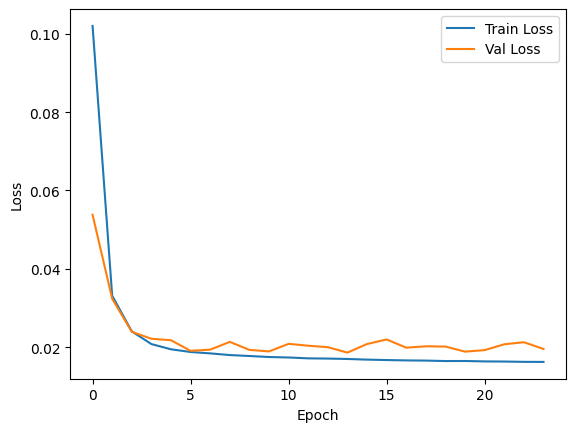

In [36]:
input_shape = (x_train_seq.shape[1], x_train_seq.shape[2])
baseline_model = build_baseline_lstm(input_shape)
baseline_history = train_model(baseline_model, x_train_seq, y_train_seq, x_val_seq, y_val_seq)

proses training dipecah jadi 3 bagian
Start: awal epoch turun dengan drastis kedua train dan val loss

Mid: pada pertengahan epoch, terlihat kedua loss yang makin kecil dan stabil, tapi tidak signifikan

Akhir: Val loss dan Train loss turun bersamaan dan gapnya tidak terlalu jauh

Kesimpulan: model berjalan dengan baik dan mengindikasikan good fit, bisa dilihat dari train loss dan val loss yang turun stabil dan ke angka loss yang rendah

# Modifikasi

- menambah layer dan unit (mampu menangkap pola lebih kompleks)
- drop out (0.2), bikin neuron randomly nonactive saat training, utk prevent overfitting
- batchnormalization (menstabilkan training)
- dense (menambah pemahaman model terhadap nonlinearitas)

In [37]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation

def build_modified_lstm(input_shape):

    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True, dropout=0.2),
        BatchNormalization(),

        LSTM(32, return_sequences=False, dropout=0.2),
        BatchNormalization(),

        Dense(16),
        BatchNormalization(),

        Dropout(0.3),
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    model.summary()

    return model


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5, 64)             22784     
                                                                 
 batch_normalization (BatchN  (None, 5, 64)            256       
 ormalization)                                                   
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 batch_normalization_2 (Batc  (None, 16)              

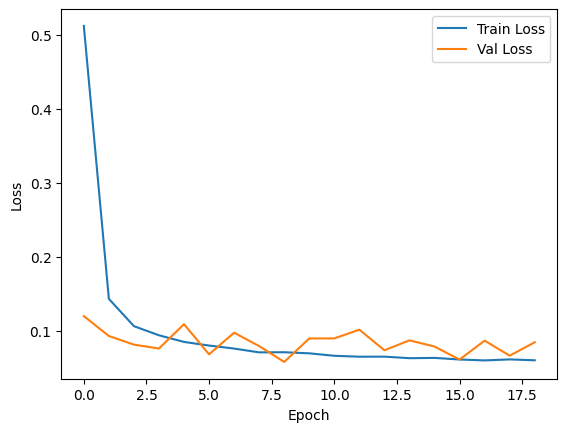

In [38]:
input_shape = (x_train_seq.shape[1], x_train_seq.shape[2])
modified_model = build_modified_lstm(input_shape)
modified_history = train_model(modified_model, x_train_seq, y_train_seq, x_val_seq, y_val_seq)

dipecah jadi 3 bagian

Start: awal epoch kedua model sudah rendah dari segi loss

Mid: pada pertengahan epoch, terlihat kedua loss yang makin kecil walau ada fluktuatif terutama di val loss

Akhir: Val loss tetap fluktuatif, tapi tetap masih relatif rendah dan batas wajar. Train loss terus menurun dan konsisten

Kesimpulan: model berjalan dengan baik dan mengindikasikan good fit, bisa dilihat dari train loss dan val loss yang turun berbarengan dan di angka yang rendah, lalu gap keduanya juga tidak jauh.

# Evaluasi

### evaluasi dengan MAE, MSE, RMSE, R2

In [41]:
def evaluate_models(models, x_test, y_test, scaler, model_names):

    results = {}

    for i, (model, name) in enumerate(zip(models, model_names)):
        print(f"\nEvaluating {name} Model:")

        y_pred_scaled = model.predict(x_test, verbose=0)

        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        y_pred_actual = scaler.inverse_transform(y_pred_scaled).flatten()

        mae = mean_absolute_error(y_test_actual, y_pred_actual)
        mse = mean_squared_error(y_test_actual, y_pred_actual)
        r2 = r2_score(y_test_actual, y_pred_actual)
        rmse = np.sqrt(mse)

        results[name] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2,
            'y_true': y_test_actual,
            'y_pred': y_pred_actual
        }

        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")

    print("\nMODEL COMPARISON")
    comparison_df = pd.DataFrame(results).T
    print(comparison_df[['MAE', 'MSE', 'R2']].round(4))

In [42]:
models = [baseline_model, modified_model]
model_names = ["Baseline LSTM", "Modified LSTM"]
results = evaluate_models(models, x_test_seq, y_test_seq, scaler_y, model_names)


Evaluating Baseline LSTM Model:
MAE: 0.5668
MSE: 0.5674
RMSE: 0.7533
R² Score: 0.9195

Evaluating Modified LSTM Model:
MAE: 1.3632
MSE: 2.6241
RMSE: 1.6199
R² Score: 0.6278

MODEL COMPARISON
                    MAE       MSE        R2
Baseline LSTM  0.566761  0.567391  0.919522
Modified LSTM  1.363219  2.624137  0.627795


Dari data ini terlihat jelas model baseline performs better. Kenapa?

ada beberapa penjelasan, salah satunya adalah overfitting pada model 2 (more kompleks)

Kesimpulan, untuk data suhu yang relatif simple, model baseline sudah cukup bagus untuk melakukan prediksi

# Hyperparameter of Baseline model (since Baseline model performs better)

In [43]:
import itertools
import pandas as pd

param_grid = {
    'units': [8, 16, 32],
    'learning_rate': [0.001, 0.005]
}

param_combinations = list(itertools.product(
    param_grid['units'],
    param_grid['learning_rate']
))

combo_df = pd.DataFrame(param_combinations, columns=['units', 'learning_rate'])
combo_df

,units,learning_rate
0,8,0.001
1,8,0.005
2,16,0.001
3,16,0.005
4,32,0.001
5,32,0.005


In [44]:
def hypertuned_model(input_shape, learning_rate, units):

    model = Sequential([
        LSTM(units, input_shape=input_shape, return_sequences=False),
        Dense(1, activation = 'linear')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    model.summary()

    return model

In [45]:
def hyperparameter_modified_lstm(x_train, y_train, x_val, y_val, return_best_model=True):
    param_grid = {
        'units': [8, 16, 32],
        'learning_rate': [0.001, 0.005]
    }

    param_combinations = list(itertools.product(
        param_grid['units'],
        param_grid['learning_rate']
    ))

    results = []
    best_model = None
    best_mae = float('inf')

    for i, (units, lr) in enumerate(param_combinations):
        print(f"\nTraining model {i+1}/{len(param_combinations)}: units={units}, lr={lr}")

        model = hypertuned_model(
            input_shape=(x_train.shape[1], x_train.shape[2]),
            units=units,
            learning_rate=lr
        )

        train_model(model, x_train, y_train, x_val, y_val)

        val_pred = model.predict(x_val, verbose=0)
        mae = mean_absolute_error(y_val, val_pred)

        results.append({
            'units': units,
            'learning_rate': lr,
            'val_mae': mae
        })

        if return_best_model and mae < best_mae:
            best_mae = mae
            best_model = model

    results_df = pd.DataFrame(results).sort_values(by='val_mae')

    if return_best_model:
        return results_df, best_model
    return results_df


Training model 1/6: units=8, lr=0.001
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8)                 1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,065
Trainable params: 1,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
610/610 [==============================] - 3s 3ms/step - loss: 0.1871 - mae: 0.3044 - val_loss: 0.0629 - val_mae: 0.1885
Epoch 2/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0435 - mae: 0.1469 - val_loss: 0.0363 - val_mae: 0.1439
Epoch 3/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0279 - mae: 0.1134 - val_loss: 0.0259 - val_mae: 0.1202
Epoch 4/10

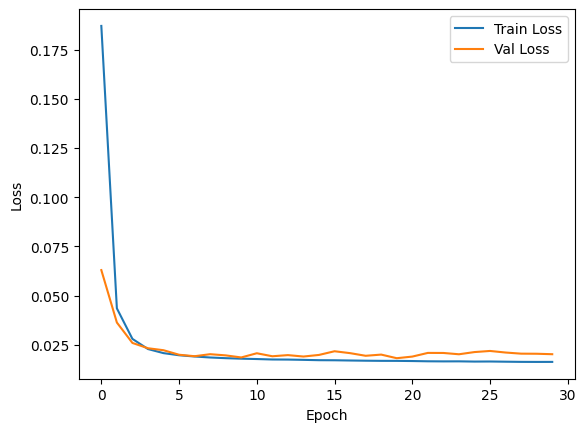


Training model 2/6: units=8, lr=0.005
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8)                 1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,065
Trainable params: 1,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
610/610 [==============================] - 3s 3ms/step - loss: 0.0592 - mae: 0.1522 - val_loss: 0.0223 - val_mae: 0.1107
Epoch 2/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0206 - mae: 0.0939 - val_loss: 0.0212 - val_mae: 0.1054
Epoch 3/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0193 - mae: 0.0905 - val_loss: 0.0224 - val_mae: 0.1096
Epoch 4/10

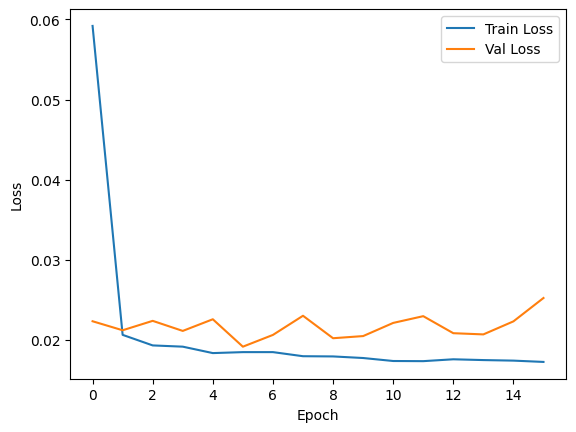


Training model 3/6: units=16, lr=0.001
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 16)                2624      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,641
Trainable params: 2,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
610/610 [==============================] - 3s 3ms/step - loss: 0.0980 - mae: 0.2170 - val_loss: 0.0536 - val_mae: 0.1799
Epoch 2/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0296 - mae: 0.1187 - val_loss: 0.0301 - val_mae: 0.1295
Epoch 3/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0217 - mae: 0.0981 - val_loss: 0.0233 - val_mae: 0.1135
Epoch 4/1

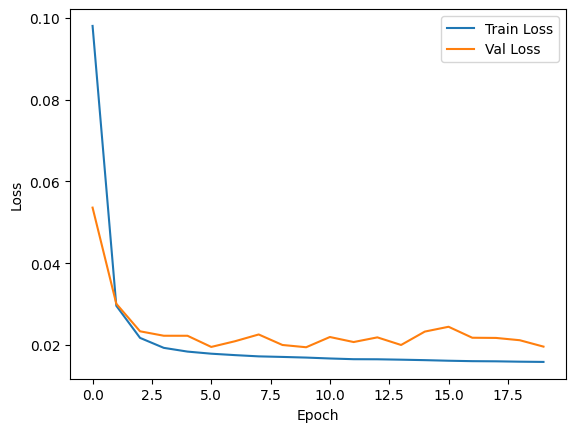


Training model 4/6: units=16, lr=0.005
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 16)                2624      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,641
Trainable params: 2,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0473 - mae: 0.1379 - val_loss: 0.0252 - val_mae: 0.1187
Epoch 2/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0203 - mae: 0.0933 - val_loss: 0.0238 - val_mae: 0.1135
Epoch 3/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0193 - mae: 0.0902 - val_loss: 0.0227 - val_mae: 0.1121
Epoch 4/1

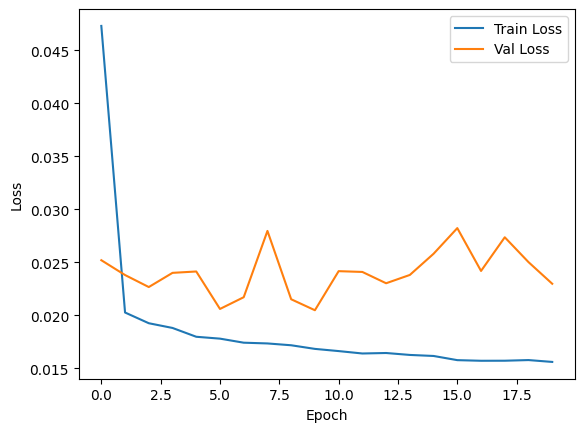


Training model 5/6: units=32, lr=0.001
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                7296      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,329
Trainable params: 7,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0730 - mae: 0.1832 - val_loss: 0.0409 - val_mae: 0.1549
Epoch 2/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0256 - mae: 0.1092 - val_loss: 0.0262 - val_mae: 0.1191
Epoch 3/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0202 - mae: 0.0939 - val_loss: 0.0243 - val_mae: 0.1155
Epoch 4/1

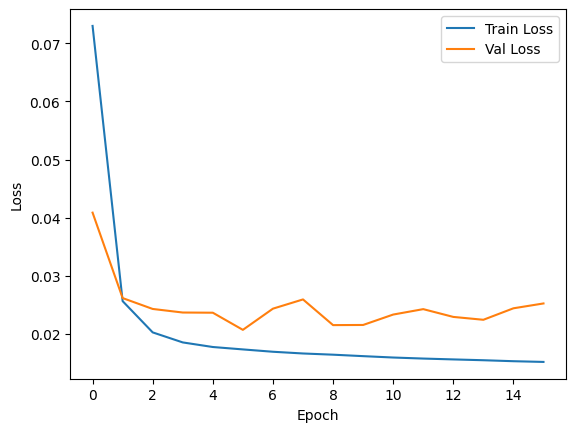


Training model 6/6: units=32, lr=0.005
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 32)                7296      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 7,329
Trainable params: 7,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
610/610 [==============================] - 3s 3ms/step - loss: 0.0350 - mae: 0.1210 - val_loss: 0.0266 - val_mae: 0.1238
Epoch 2/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0196 - mae: 0.0911 - val_loss: 0.0243 - val_mae: 0.1163
Epoch 3/100
610/610 [==============================] - 2s 3ms/step - loss: 0.0185 - mae: 0.0888 - val_loss: 0.0251 - val_mae: 0.1163
Epoch 4/1

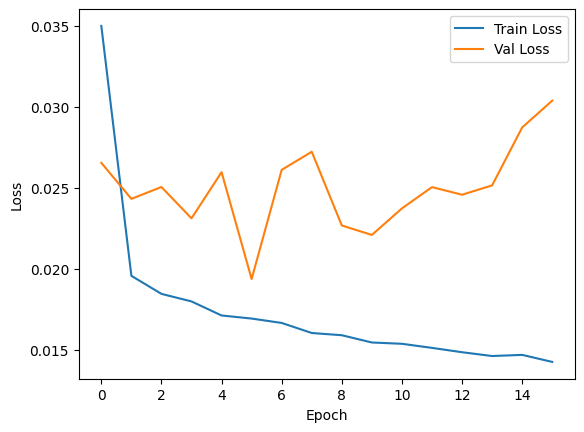

In [46]:
results_df, best_model = hyperparameter_modified_lstm(x_train_seq, y_train_seq, x_val_seq, y_val_seq)

In [48]:
evaluate_models(
    models=[best_model],
    x_test=x_test_seq,
    y_test=y_test_seq,
    scaler=scaler_y,
    model_names=["Best Modified LSTM"]
)


Evaluating Best Modified LSTM Model:
MAE: 0.5433
MSE: 0.5321
RMSE: 0.7294
R² Score: 0.9245

MODEL COMPARISON
                         MAE       MSE        R2
Best Modified LSTM  0.543349  0.532076  0.924531


In [49]:
best_params = results_df.iloc[0]
print("Units:", best_params['units'])
print("Learning Rate:", best_params['learning_rate'])

Units: 8.0
Learning Rate: 0.001


dari sini bisa diambil kesimpulan model baseline dengan 8 hidden size dan 0.001 learning rate perform paling bagus. Salah satu alasannya adalah karena data yang relatif simpel dan tidak membuat model menjadi kesulitan dalam belajar, sehingga tidak memerlukan jumlah neuron dan layer yang banyak, karena jika berlebihan, bisa terjadi overfitting (model mempelajari fitur terlalu detail, sampai fitur tersebut dianggap penting padahal tidak).

Maka dari itu, terlihat bahwa model dengan unit 8 itu menjadi yang paling bagus performanya